# Training a triplet loss siamese neural network with stochastic quantization model

Importing all required third-party dependencies

In [1]:
import os
import itertools

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib as mpl
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay, f1_score

import sq.optim as sq_optim
import sq.quantization as sq

Choosing a different algorithm for convolutions computations

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

To enforce reproducibility we set the random seed manually

In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"Used random seed: {torch.initial_seed()}")

Used random seed: 42


We set up the computation device for performing optimization

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"

We will use MNIST dataset of handwritten digits

In [5]:
EPOCHS = 50

BATCH_TRAIN = 1024
BATCH_TEST = 10000
DATA_DIR = '../../data/'
RESULTS_DIR = '../../results/'

train_dataset = datasets.MNIST(
    root=DATA_DIR, train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

test_dataset = datasets.MNIST(
    root=DATA_DIR, train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=True)

These are examples of handwritten digits from the dataset

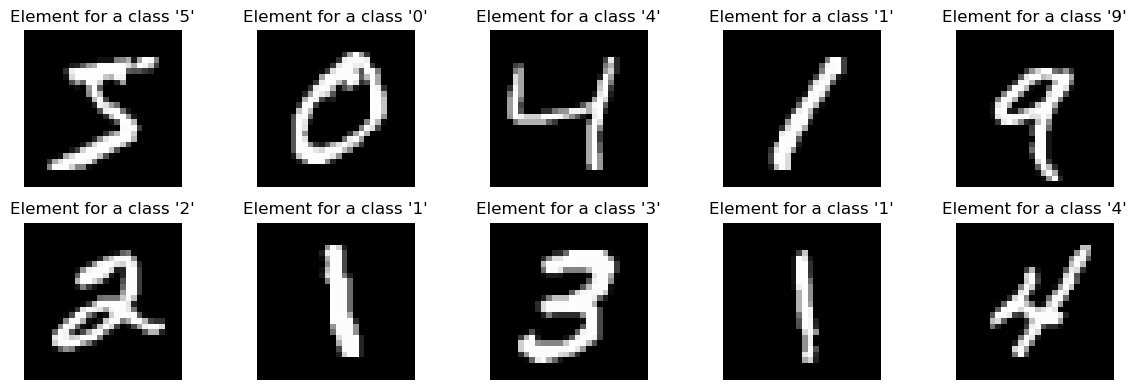

In [6]:
# Selecting random samples for the visual showcase
row_elements = 5

fig, axes = plt.subplots(2, row_elements, figsize=(12, 4), tight_layout=True)

# Display the samples in the image grid
for i, (image, label) in enumerate(
  itertools.islice(train_dataset, 2 * row_elements)
):
    row = i // row_elements
    col = i % row_elements

    axes[row, col].imshow(image.squeeze(), cmap="gray")
    axes[row, col].set_title(f"Element for a class '{label}'")
    axes[row, col].axis("off")

# Show the plot
plt.show()

A blueprint for a siamese neural network

In [7]:
class SiameseModel(nn.Module):    
    def __init__(self, latent_dim=16):
        super(SiameseModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Flatten(),

            nn.Linear(64 * 7 * 7, 1000),
            nn.ELU(),

            nn.Linear(1000, latent_dim),
        )

    def forward(self, x):
        return self.encoder(x)

Triplets are mined as semi-hard category in the online mode

In [8]:
def get_semihard_triplets(embeddings, labels, margin=1.0):
    pairwise_dist = torch.cdist(embeddings, embeddings)

    # Create a mask for positive pairs (same label)
    labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
    positive_mask = labels_equal.to(embeddings.device)

    # Create a mask for negative pairs (different label)
    negative_mask = ~positive_mask

    # Exclude self-comparisons
    mask_no_self = ~torch.eye(embeddings.shape[0], dtype=torch.bool, device=embeddings.device)
    positive_mask = positive_mask & mask_no_self
    negative_mask = negative_mask & mask_no_self

    # Find hardest positive for each anchor
    hardest_positive_dist, _ = (pairwise_dist * positive_mask.float()).max(dim=1)

    # Find semi-hard negatives for each anchor
    semi_hard_negative_mask = (pairwise_dist > hardest_positive_dist.unsqueeze(1)) & \
                              (pairwise_dist < hardest_positive_dist.unsqueeze(1) + margin) & \
                              negative_mask

    # If no semi-hard negative exists, use the hardest negative
    for i in range(embeddings.shape[0]):
        if not semi_hard_negative_mask[i].any():
            hard_negative_dist, hard_negative_idx = (pairwise_dist[i] * negative_mask[i].float()).min(dim=0)
            semi_hard_negative_mask[i, hard_negative_idx] = True

    # Sample triplets
    anchors = []
    positives = []
    negatives = []

    for i in range(embeddings.shape[0]):
        positive_indices = torch.where(positive_mask[i])[0]
        negative_indices = torch.where(semi_hard_negative_mask[i])[0]

        if len(positive_indices) > 0 and len(negative_indices) > 0:
            positive_idx = positive_indices[torch.randint(0, len(positive_indices), (1,))]
            negative_idx = negative_indices[torch.randint(0, len(negative_indices), (1,))]

            anchors.append(embeddings[i])
            positives.append(embeddings[positive_idx].squeeze(0))
            negatives.append(embeddings[negative_idx].squeeze(0))

    return torch.stack(anchors), torch.stack(positives), torch.stack(negatives)

Building an instance of a siamese neural network and training it on a triplet loss

In [9]:
LATENT_DIM = 2
TRIPLET_MARGIN = 2.0

siamese_model = SiameseModel(latent_dim=LATENT_DIM).to(device)
criterion = nn.TripletMarginLoss(margin=TRIPLET_MARGIN, p=2)
optimizer = optim.Adam(siamese_model.parameters(), lr=1e-3, weight_decay=1e-05)

train_loss, val_loss = [], []


for epoch in range(EPOCHS):
    epoch_train_loss = []
    epoch_val_loss = []

    # Training loss and accuracy
    siamese_model.train()

    for images, labels in (progress_bar := tqdm(train_dataloader)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()

        output = siamese_model(images)
        loss = criterion(*get_semihard_triplets(output, labels, margin=TRIPLET_MARGIN))

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_train_loss.append(loss.item())
        progress_bar.set_description(f"Train loss: {loss.item():.4f}")

    train_loss.append(np.mean(np.array(epoch_train_loss)))

    # Validation loss and accuracy
    siamese_model.eval()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = siamese_model(images)
            loss = criterion(*get_semihard_triplets(output, labels))

            epoch_val_loss.append(loss.item())

    val_loss.append(np.mean(np.array(epoch_val_loss)))

    print(f"Validation loss: {loss.item():.4f}")

Train loss: 0.0250: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.22it/s]


Validation loss: 0.0524


Train loss: 0.0233: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.27it/s]


Validation loss: 0.0035


Train loss: 0.0303: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.23it/s]


Validation loss: 0.0009


Train loss: 0.0180: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:29<00:00,  1.97it/s]


Validation loss: 0.0033


Train loss: 0.1162: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:30<00:00,  1.93it/s]


Validation loss: 0.0021


Train loss: 0.0516: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:29<00:00,  1.98it/s]


Validation loss: 0.0017


Train loss: 0.1026: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:29<00:00,  2.03it/s]


Validation loss: 0.0019


Train loss: 0.7886: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:29<00:00,  2.03it/s]


Validation loss: 0.0015


Train loss: 0.0165: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:29<00:00,  2.03it/s]


Validation loss: 0.0025


Train loss: 0.1036: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:27<00:00,  2.12it/s]


Validation loss: 0.0016


Train loss: 0.0825: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.25it/s]


Validation loss: 0.0024


Train loss: 0.3932: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.25it/s]


Validation loss: 0.0026


Train loss: 0.2645: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.24it/s]


Validation loss: 0.0013


Train loss: 0.2950: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.28it/s]


Validation loss: 0.0056


Train loss: 0.0393: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.25it/s]


Validation loss: 0.0017


Train loss: 0.3790: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.30it/s]


Validation loss: 0.0021


Train loss: 0.1147: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.27it/s]


Validation loss: 0.0026


Train loss: 0.0210: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.31it/s]


Validation loss: 0.0026


Train loss: 0.0477: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.28it/s]


Validation loss: 0.0030


Train loss: 0.3348: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.26it/s]


Validation loss: 0.0016


Train loss: 0.0395: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:24<00:00,  2.38it/s]


Validation loss: 0.0018


Train loss: 0.3015: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.34it/s]


Validation loss: 0.0020


Train loss: 0.0428: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.29it/s]


Validation loss: 0.0024


Train loss: 0.1210: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.33it/s]


Validation loss: 0.0034


Train loss: 0.1496: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.30it/s]


Validation loss: 0.0023


Train loss: 0.0634: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.32it/s]


Validation loss: 0.0017


Train loss: 0.0397: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.31it/s]


Validation loss: 0.0006


Train loss: 0.7227: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.29it/s]


Validation loss: 0.0015


Train loss: 0.1506: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.27it/s]


Validation loss: 0.0018


Train loss: 0.3142: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.27it/s]


Validation loss: 0.0025


Train loss: 0.0447: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.24it/s]


Validation loss: 0.0014


Train loss: 0.0999: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.28it/s]


Validation loss: 0.0023


Train loss: 0.4171: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.27it/s]


Validation loss: 0.0020


Train loss: 0.0467: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.30it/s]


Validation loss: 0.0022


Train loss: 0.0807: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.26it/s]


Validation loss: 0.0027


Train loss: 0.0806: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.29it/s]


Validation loss: 0.0040


Train loss: 0.1764: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.25it/s]


Validation loss: 0.0034


Train loss: 0.0494: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.29it/s]


Validation loss: 0.0035


Train loss: 0.3891: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.28it/s]


Validation loss: 0.0018


Train loss: 0.2863: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.28it/s]


Validation loss: 0.0017


Train loss: 0.5720: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.28it/s]


Validation loss: 0.0022


Train loss: 0.5555: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.28it/s]


Validation loss: 0.0033


Train loss: 0.0242: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.27it/s]


Validation loss: 0.0020


Train loss: 0.2789: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.25it/s]


Validation loss: 0.0022


Train loss: 0.1429: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.25it/s]


Validation loss: 0.0014


Train loss: 0.1768: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.27it/s]


Validation loss: 0.0028


Train loss: 0.5629: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.28it/s]


Validation loss: 0.0020


Train loss: 0.4358: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.25it/s]


Validation loss: 0.0021


Train loss: 0.0971: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.30it/s]


Validation loss: 0.0012


Train loss: 0.5167: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:25<00:00,  2.31it/s]


Validation loss: 0.0030


We compare train and validation losses to detect the overfitting of the model

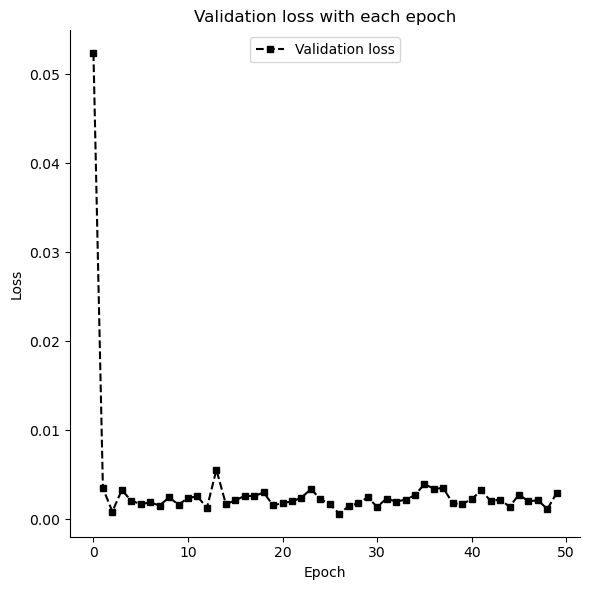

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

ax.plot(range(len(val_loss)), val_loss, linestyle='--',
           marker='s', color='k', markersize=4, label="Validation loss")

ax.set_title("Validation loss with each epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc="upper center")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.patch.set_facecolor('white')

plt.show()

We convert all handwritten digits from the dataset to visualize their embeddings in the metric space

In [11]:
def group_embeddings_by_label(model: nn.Module, dataloader: DataLoader):
    all_embeddings = np.empty((0, LATENT_DIM))
    grouped_embeddings = {i: np.empty((0, LATENT_DIM)) for i in range(10)}

    for img, lbs in dataloader:
        model_device = next(model.parameters()).device
        batch_embeddings = model(img.to(model_device))
        batch_embeddings = batch_embeddings.cpu().detach().numpy()

        lbs = lbs.detach().numpy()

        for emb, lb in zip(batch_embeddings, lbs):
            grouped_embeddings[lb] = np.vstack((grouped_embeddings[lb], np.array(emb)))

    for cl, embeds in grouped_embeddings.items():
        all_embeddings = np.vstack((all_embeddings, np.array(embeds)))

    return grouped_embeddings, all_embeddings


embedding_model = siamese_model.encoder

with torch.no_grad():
    train_group_embeds, train_all_embeds = group_embeddings_by_label(embedding_model, train_dataloader)
    test_group_embeds, test_all_embeds = group_embeddings_by_label(embedding_model, test_dataloader)

We compare the low-level representations distribution on the 2D scatter plot

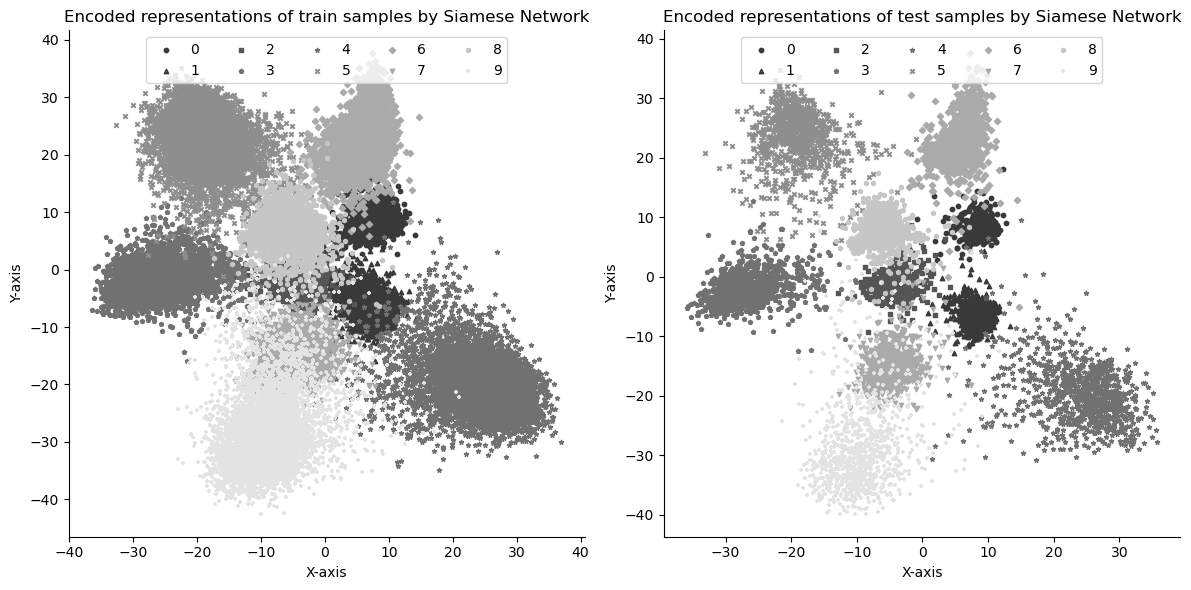

In [12]:
markers = ['o', '^', 's', 'p', '*', 'x', 'D', 'v', 'h', '+']
markers_color = mpl.colormaps['gray'].resampled(len(markers))
markers_color_range = np.linspace(0.2, 0.8, len(markers))
marksize = 10

fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

for idx, (cls, embeds) in enumerate(train_group_embeds.items()):
    cls_color = markers_color(markers_color_range[idx])

    ax[0].scatter(embeds[:, 0], embeds[:, 1], color=cls_color, label=cls,
                  alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax[0].legend(loc="upper center", ncol=5)
ax[0].set_title('Encoded representations of train samples by Siamese Network')

ax[0].set_xlabel('X-axis')
ax[0].set_ylabel('Y-axis')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

for idx, (cls, embeds) in enumerate(test_group_embeds.items()):
    cls_color = markers_color(markers_color_range[idx])

    ax[1].scatter(embeds[:, 0], embeds[:, 1], color=cls_color, label=cls, alpha=1.0,
                  s=marksize, marker=markers[idx % len(markers)])

ax[1].legend(loc="upper center", ncol=5)
ax[1].set_title('Encoded representations of test samples by Siamese Network')

ax[1].set_xlabel('X-axis')
ax[1].set_ylabel('Y-axis')

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

fig.patch.set_facecolor('white')

plt.show()

We will use stochastic quantization algorithm for the non-convex optimization problem of representations clustering

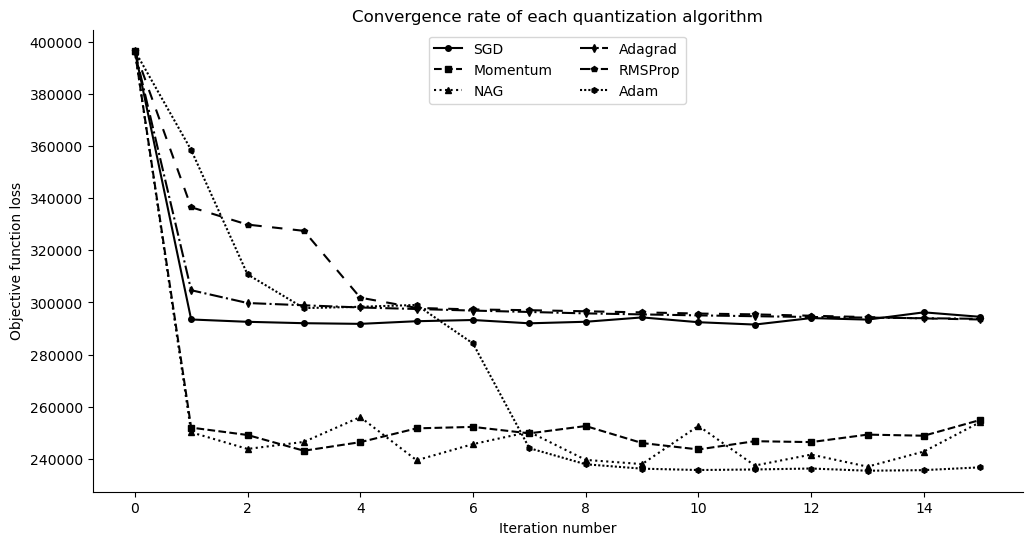

In [13]:
SQ_ITERS = 15

sq_algorithms = {
    "SGD": sq.StochasticQuantization(sq_optim.SGDOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                     random_state=np.random.RandomState(RANDOM_SEED)),
    "Momentum": sq.StochasticQuantization(sq_optim.MomentumOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                          learning_rate=0.001, random_state=np.random.RandomState(RANDOM_SEED)),
    "NAG": sq.StochasticQuantization(sq_optim.NAGOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                     learning_rate=0.001, random_state=np.random.RandomState(RANDOM_SEED)),
    "Adagrad": sq.StochasticQuantization(sq_optim.AdagradOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                         learning_rate=0.5, random_state=np.random.RandomState(RANDOM_SEED)),
    "RMSProp": sq.StochasticQuantization(sq_optim.RMSPropOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                         random_state=np.random.RandomState(RANDOM_SEED)),
    "Adam": sq.StochasticQuantization(sq_optim.AdamOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                      learning_rate=0.01, random_state=np.random.RandomState(RANDOM_SEED))
}

markers = [('o', '-'), ('s', '--'), ('^', ':'), ('d', '-.'), ('p', (0, (5, 5))), ('h', (0, (1, 1)))]
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    marker, linestyle = markers[idx % len(markers)]

    alg = alg.fit(train_all_embeds)

    ax.plot(range(len(alg.loss_history_)), alg.loss_history_,
            linestyle=linestyle, marker=marker, color='k',
            markersize=4, label=name)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Convergence rate of each quantization algorithm")
plt.xlabel('Iteration number')
plt.ylabel('Objective function loss')
plt.legend(loc="upper center", ncol=2)
plt.show()

We use confusion matrix to compare the accuracy of classification model for each class

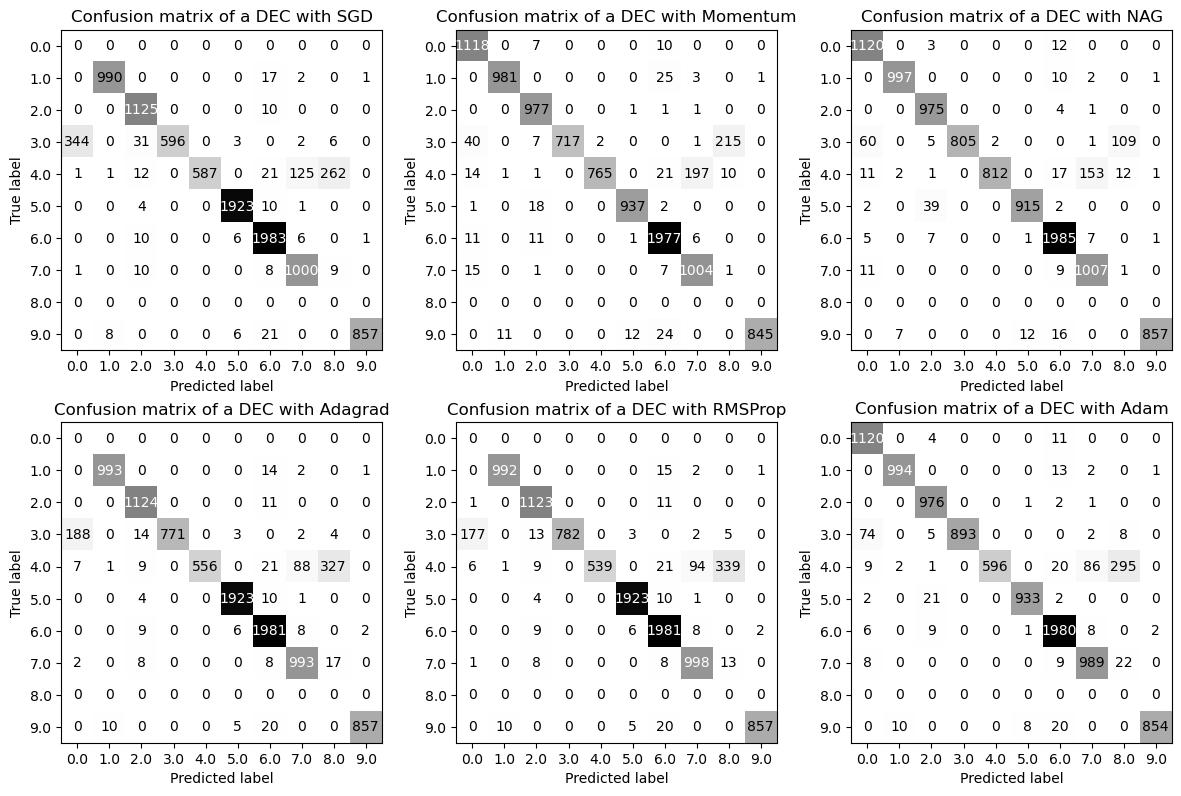

In [14]:
n_col, n_row = (2, 3)
fig, ax = plt.subplots(n_col, n_row, figsize=(12, 8), tight_layout=True)
f1_scores = {}

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    y_true, y_pred = np.array([]), np.array([])

    for _, embs in test_group_embeds.items():
        cls = alg.predict(embs)
        cls_predicted = np.bincount(cls).argmax()

        y_true = np.append(y_true, np.full((1, len(embs)), cls_predicted))
        y_pred = np.append(y_pred, cls)

    ax_idx = ax[idx // n_row, idx % n_row]

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, cmap="Greys", colorbar=False, ax=ax_idx
    )

    ax_idx.set_title(f"Confusion matrix of a DEC with {name}")
    f1_scores[name] = f1_score(y_true, y_pred, average="weighted")

plt.show()

To account for label imbalance in the test set, we choose a weighted F1 score as an accuracy metric.

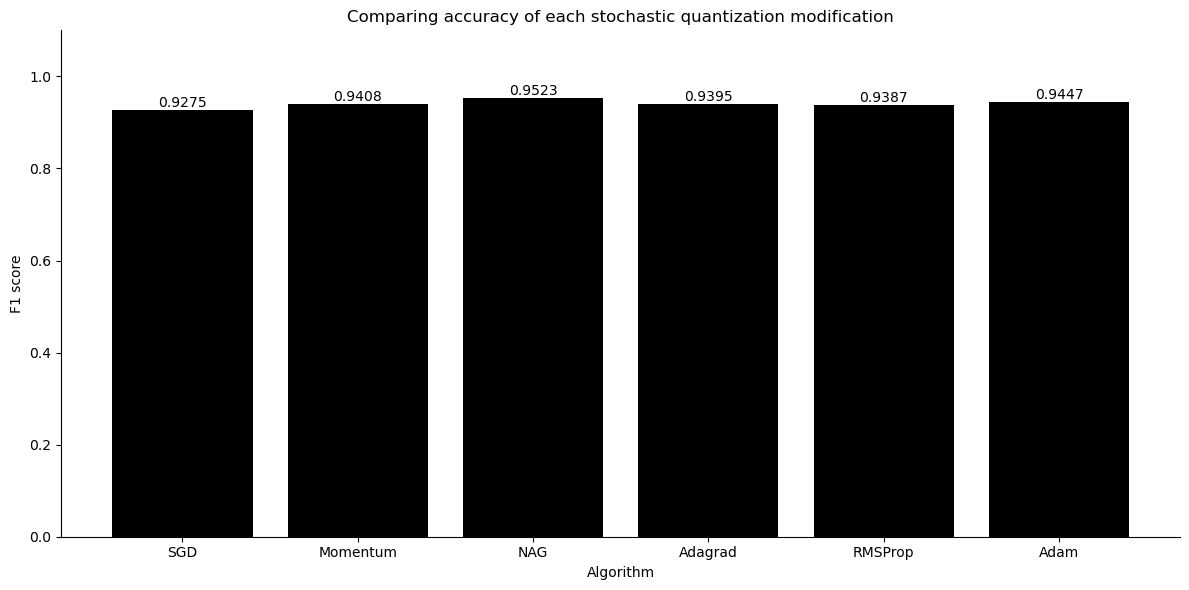

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)

bars = ax.bar(f1_scores.keys(), f1_scores.values(), color='k')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0,
            height, f'{round(height, 4)}', ha='center', va='bottom')

ax.set_xlabel("Algorithm")
ax.set_ylabel("F1 score")
ax.set_title("Comparing accuracy of each stochastic quantization modification")
ax.set_ylim(top=1.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Save encoder model for the later use

In [16]:
MODEL_DIR = os.path.join(RESULTS_DIR, "model")

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

embedding_model.eval()

torch.save(embedding_model.state_dict(), os.path.join(MODEL_DIR, "siamese_model.bin"))